# BSTS: Bayesian Structural Time Series

In general we'll explore what we see here:
https://www.takayabe.net/post/pystan-bsts

Let's see if we can implement something similar in pymc3 and do the counterfactual analysis they did here. We want to model what happens before a treatment is applied, then extend a prediction to create a counterfactual for what would have happened had the treatment not been applied. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import xarray as xr
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-darkgrid')

### synthetic data

we follow the tutorial in generating synthetic data over 150 time points with a treatment spike at t=100 which then decays exponentially. 

In [3]:
treatment_idx = 100
n = 150
np.random.seed(1234)
x = np.zeros(n)
beta = 1
mu = np.random.normal(n, 1, n)
tau = np.tile(np.asarray([-10,0,5,-5,10]),30)
treatment = np.concatenate((np.zeros(treatment_idx),20*np.exp(-0.08*np.arange(n-treatment_idx))))
y = mu+tau+treatment+x*beta

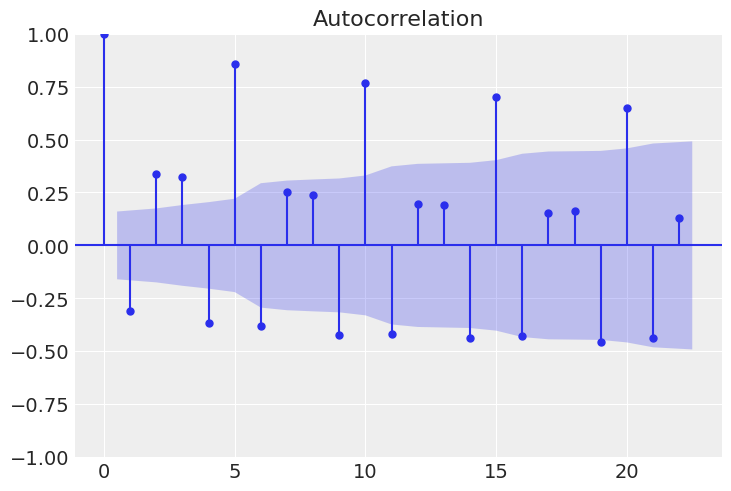

In [4]:
plot_acf(y)
plt.show()

# seasonality of 5

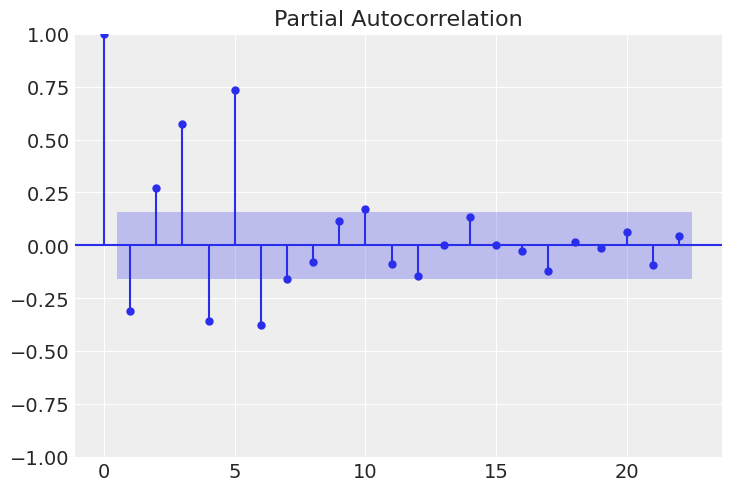

In [5]:
plot_pacf(y)
plt.show()

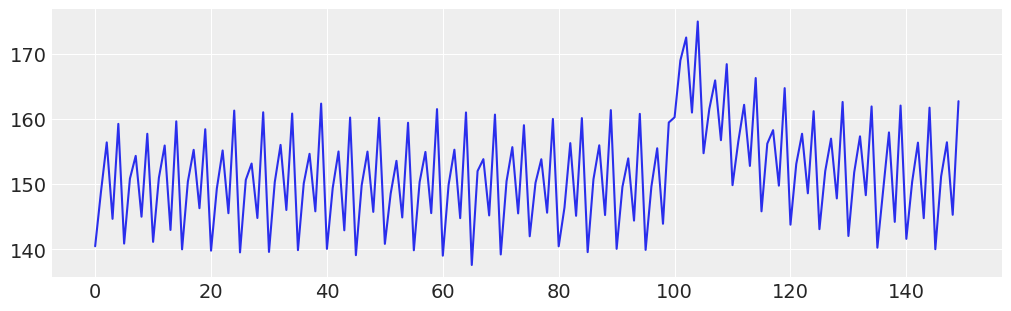

In [6]:
fig,ax = plt.subplots(figsize=(10,3))
ax.plot(y)
plt.show()

### Model Pre-Treatment

In [7]:
t_pre = np.arange(0, treatment_idx)
y_pre = y[0:treatment_idx]

In [8]:

priors = {
            "sigma": 1,
            "alpha":{"mu":150, "sigma":5},
            "beta":{"mu":0, "sigma":1},
            "amp":{"mu":20, "sigma":10},
            "freq":{"alpha":1,"beta":1}
        }

with pm.Model() as bsts:
    bsts.add_coords({"obs_id": range(treatment_idx)})
    time = pm.MutableData("t_pre", t_pre, dims="obs_id")
    vals = pm.MutableData("y_pre", y_pre, dims="obs_id")


    alpha = pm.Normal("alpha", priors["alpha"]["mu"], priors["alpha"]["sigma"])
    beta = pm.Normal("beta", priors["beta"]["mu"], priors["beta"]["sigma"])
    trend = pm.Deterministic("trend", alpha + beta * t_pre, dims="obs_id")

    # SEASONAL params

    # beta prior for frequency since it's between 0 and 1; let's give ourselves an easier
    freq = pm.Beta("freq", alpha=priors["freq"]["alpha"], beta = priors["freq"]["beta"])
    # kind of a crappy choice of prior for amplitude but we could do worse
    amp = pm.Normal("amp", mu=priors["amp"]["mu"], sigma = priors["amp"]["sigma"])
    phase = pm.Uniform("phase", lower = -0.5, upper=0.5) # in this case we can hard code phase...we just pick uniform over the range
    
    seasonal = pm.Deterministic("seasonal", amp*np.sin(2*np.pi*freq*(t_pre + phase)), dims="obs_id")
    
    mu = trend + seasonal

    sigma = pm.HalfNormal("sigma", priors["sigma"])
    outcome = pm.Normal("vals", mu=mu, sigma=sigma, observed=y_pre, dims="obs_id")

    trace = pm.sample(draws=1000,tune=1000)
    idata = pm.sample_posterior_predictive(trace, random_seed=232)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, freq, amp, phase, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [vals]


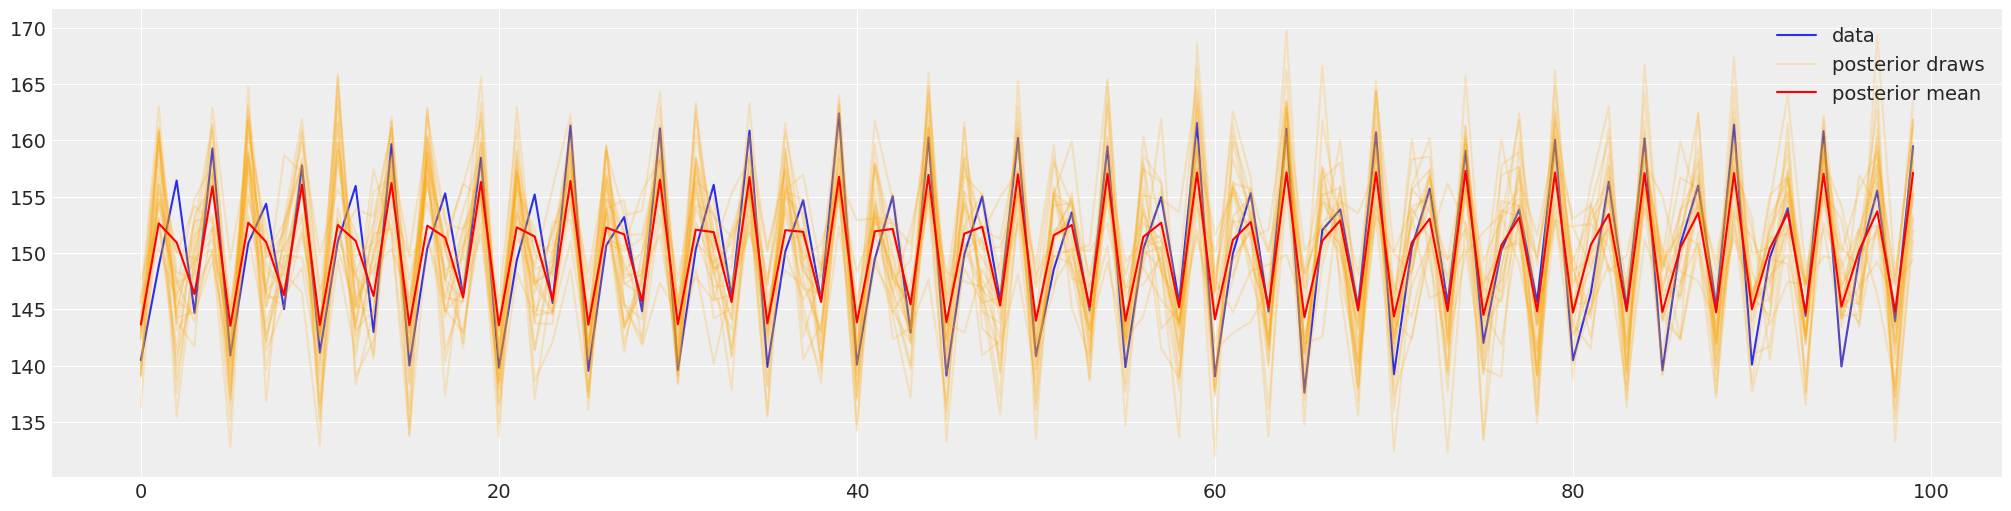

In [9]:
plt.figure(figsize=(20,5))
plt.plot(t_pre, y_pre, label='data')
k=20
for i in range(k):
    plt.plot(t_pre, idata.posterior_predictive.vals[0][200+5*i], color='orange', alpha=0.2) 
plt.plot(t_pre, idata.posterior_predictive.vals[0][200+(5*k)+1], color='orange', alpha=0.2, label='posterior draws')
plt.plot(t_pre, idata.posterior_predictive.vals.mean(["chain", "draw"]), color='red', label='posterior mean')
plt.legend()

### Generate Counterfactual

now predict values from this trained model forward

In [10]:
projection_steps = n-treatment_idx
with bsts:
    bsts.add_coords({"obs_id_fut": range(treatment_idx,treatment_idx+projection_steps,1 )})

    t_fut = pm.MutableData(
        "t_fut", list(range(treatment_idx, treatment_idx+projection_steps, 1)), dims="obs_id_fut"
    )


    trend_fut = pm.Deterministic("trend_fut", alpha + beta * t_fut, dims="obs_id_fut")
    seasonal_fut = pm.Deterministic("seasonal_fut", amp*np.sin(2*np.pi*freq*(t_fut + phase)), dims="obs_id_fut")
    mu = trend_fut + seasonal_fut
    
    yhat_fut = pm.Normal("yhat_fut", mu=mu, sigma=sigma, dims="obs_id_fut")


    # use the updated values and predict outcomes and probabilities:
    trace_future =  pm.sample(draws=2000,tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, freq, amp, phase, sigma, yhat_fut]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [13]:
trace_future.posterior

<xarray.Dataset>
Dimensions:       (chain: 4, draw: 2000, obs_id_fut: 50, obs_id: 100)
Coordinates:
  * chain         (chain) int64 0 1 2 3
  * draw          (draw) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * obs_id_fut    (obs_id_fut) int64 100 101 102 103 104 ... 145 146 147 148 149
  * obs_id        (obs_id) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Data variables:
    alpha         (chain, draw) float64 149.4 150.9 150.9 ... 148.7 149.4 150.6
    beta          (chain, draw) float64 0.002065 -0.008485 ... 0.01 -0.01679
    amp           (chain, draw) float64 8.836 9.422 9.523 ... 8.783 8.174 8.316
    yhat_fut      (chain, draw, obs_id_fut) float64 142.6 147.8 ... 143.4 155.1
    freq          (chain, draw) float64 0.3975 0.3975 0.3975 ... 0.3976 0.3978
    phase         (chain, draw) float64 -0.4827 -0.4982 ... -0.4979 -0.4967
    sigma         (chain, draw) float64 4.056 3.891 3.83 ... 3.733 3.856 3.829
    trend         (chain, draw, obs_id) float64 149.4 149.4 ... 148.9 148.9
    seasonal      (chain, draw, obs_id) float64 -8.253 8.495 ... -8.138 7.54
    trend_fut     (chain, draw, obs_id_fut) float64 149.7 149.7 ... 148.1 148.1
    seasonal_fut  (chain, draw, obs_id_fut) float64 -3.318 -2.262 ... 3.481
Attributes:
    created_at:                 2024-09-25T20:00:11.958675
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.10.2
    sampling_time:              20.308818101882935
    tuning_steps:               1000

In [17]:
trace_future.posterior.yhat_fut.mean(["chain", "draw"])

<xarray.DataArray 'yhat_fut' (obs_id_fut: 50)>
array([147.14819309, 149.50769491, 154.64868755, 144.10753471,
       155.77009927, 147.67816558, 149.10019798, 154.86523092,
       144.42746028, 155.26035066, 148.27407526, 148.68877029,
       154.94530966, 144.67334994, 154.74335008, 148.97502221,
       148.28642074, 155.06780698, 144.95403929, 154.18988321,
       149.59736083, 147.79167944, 155.16437098, 145.3159707 ,
       153.68539407, 150.23894768, 147.38566015, 155.3409424 ,
       145.63230828, 153.16662089, 150.91373398, 146.97349056,
       155.4328252 , 145.972868  , 152.57303431, 151.66213985,
       146.59824343, 155.53570829, 146.30505794, 151.9772361 ,
       152.21385183, 146.11225299, 155.58647026, 146.67143557,
       151.38566102, 152.94229477, 145.69371585, 155.7526499 ,
       147.0398754 , 150.84037177])
Coordinates:
  * obs_id_fut  (obs_id_fut) int64 100 101 102 103 104 ... 145 146 147 148 149

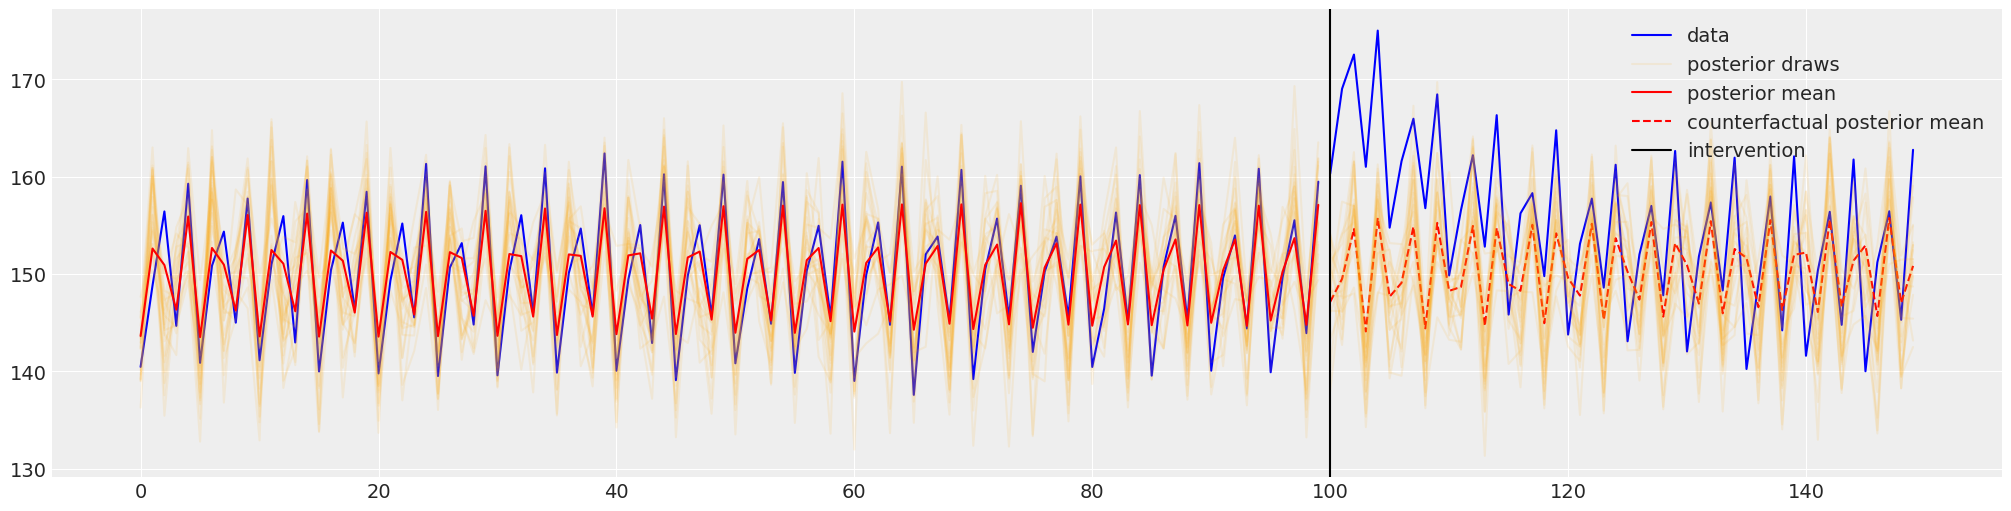

In [33]:
t= np.arange(0,n)
t_post = t[treatment_idx:]
y_post = y[treatment_idx:]


plt.figure(figsize=(20,5))
plt.plot(t_pre, y_pre, color='blue', label='data')
k=20
for i in range(k):
    plt.plot(t_pre, idata.posterior_predictive.vals[0][200+5*i], color='orange', alpha=0.1) 
plt.plot(t_pre, idata.posterior_predictive.vals[0][200+(5*k)+1], color='orange', alpha=0.1, label='posterior draws')
plt.plot(t_pre, idata.posterior_predictive.vals.mean(["chain", "draw"]), color='red', label='posterior mean')

plt.plot(t_post, y_post, color='blue')
plt.plot(t_post, trace_future.posterior.yhat_fut.mean(["chain", "draw"]), color='red', label='counterfactual posterior mean', linestyle='--')
for i in range(k):
    plt.plot(t_post, trace_future.posterior.yhat_fut[0][200+5*i], color='orange', alpha=0.1) 

plt.axvline(100, label='intervention', color='black')
plt.legend()

### Inspect Effect


Effect = Real - Counterfactual

In [35]:
trace_future.posterior.yhat_fut

<xarray.DataArray 'yhat_fut' (chain: 4, draw: 2000, obs_id_fut: 50)>
array([[[142.64262734, 147.81740901, 153.55113451, ..., 157.05893515,
         136.52079751, 146.09300171],
        [142.09431318, 142.85774422, 158.14482351, ..., 171.46093871,
         139.87404661, 151.11165499],
        [142.30407247, 143.07067891, 159.0059853 , ..., 169.24917876,
         139.34119514, 152.35653244],
        ...,
        [149.87539612, 154.41765694, 161.10221169, ..., 158.2390289 ,
         146.18560623, 150.58421141],
        [147.00047671, 141.74031111, 161.73767568, ..., 163.40324791,
         139.61735804, 149.51153205],
        [146.03022716, 151.92670408, 152.03078774, ..., 155.41391205,
         144.12108403, 153.64652471]],

       [[141.94777392, 156.83074736, 152.84413191, ..., 156.66628694,
         155.45834866, 151.62898404],
        [144.61187758, 149.77307068, 137.90922718, ..., 135.62153631,
         147.70837166, 136.77290329],
        [146.77724646, 153.04223651, 156.17964552, ..., 149.86318408,
         159.29687207, 150.41032429],
...
        [143.07490903, 152.62395983, 156.74398114, ..., 158.92658689,
         139.99569272, 155.86408308],
        [156.87652795, 137.36783599, 157.39036716, ..., 158.02129475,
         148.43599322, 147.87556334],
        [140.29250238, 152.67456063, 160.95060761, ..., 157.66612355,
         143.07789208, 153.12382294]],

       [[146.74917095, 138.09718243, 155.57737317, ..., 154.10010286,
         145.42106644, 151.13308948],
        [149.12483523, 158.89813473, 159.82932166, ..., 166.3059287 ,
         146.47572306, 149.53941112],
        [145.33256067, 152.48655545, 155.41945977, ..., 154.49485503,
         149.44014201, 160.81987921],
        ...,
        [139.46362739, 151.1908632 , 157.52017083, ..., 163.13928785,
         141.14987773, 154.81935776],
        [150.35014427, 153.02256618, 164.2012532 , ..., 158.94403904,
         141.34242281, 146.67992882],
        [148.45481505, 146.46935723, 149.81031511, ..., 155.20606805,
         143.42014708, 155.12644599]]])
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * obs_id_fut  (obs_id_fut) int64 100 101 102 103 104 ... 145 146 147 148 149

In [41]:
ts = y_post - trace_future.posterior.yhat_fut[:][:]

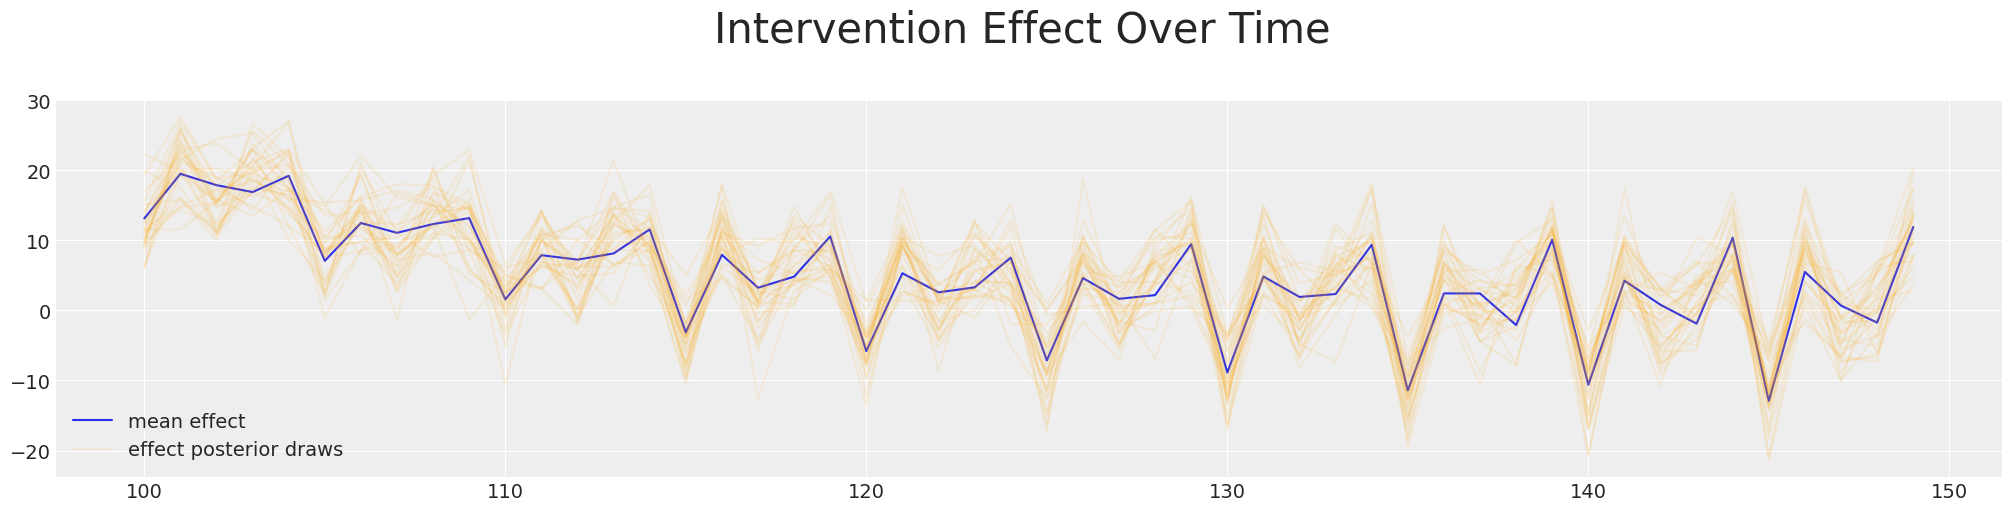

In [56]:
plt.figure(figsize=(20,5))
plt.plot(t_post, ts.mean(['chain', 'draw']), label='mean effect')
k = 30
for i in range(k):
    plt.plot(t_post, ts[0][200+5*i], color='orange', alpha=0.1) 
plt.plot(t_post, ts[0][200+(5*k)+1], color='orange', alpha=0.1, label='effect posterior draws')
plt.title('Intervention Effect Over Time \n', size=30)
plt.legend()


### Discussion

What we see is that we do have a clear intervention effect, starting up at 10-20 but then decaying over time. So we were able to capture the intervention effect we generated. However, we also see that our model didn't capture the seasonal component of our original dataset perfectly, creating an aberration / statistical artifact that looks like a regular cyclical component. Even after our intervention dies to 0 this "ringing" continues. It's what we might expect in real life--and if we notice it, it's something we could try to smooth out, or address by upgrading our modeling until white noise residuals are achieved!